### Workflow:
- Import Dependencies
- Load Data
- Parse Raw Data
- Preprocess Data
- Build Model
- Optimize Learning Rate
- Train Model
- Predict Future!

This time I'll be using the [Daily Minimum Temperatures in Melbourne](https://github.com/jbrownlee/Datasets/blob/master/daily-min-temperatures.csv) dataset which contains data of the daily minimum temperatures recorded in Melbourne from 1981 to 1990.

### Import dependencies

In [1]:
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass
from absl import logging
logging.set_verbosity(logging.ERROR)

In [3]:
TEMPERATURES_CSV = './data.csv'

with open(TEMPERATURES_CSV, 'r') as csvfile:
    print(f"Header looks like this:\n\n{csvfile.readline()}")    
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")

Header looks like this:

"Date","Temp"

First data point looks like this:

"1981-01-01",20.7

Second data point looks like this:

"1981-01-02",17.9



In [4]:
# Function for plotting series
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

### Parsing the raw data

In [5]:
def parse_data_from_file(filename):
    
    times = []
    temperatures = []

    with open(filename) as csvfile:
        index = 0
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        
        for row in reader:
            times.append(index)
            temperatures.append(float(row[1]))
            index += 1
            
    return times, temperatures

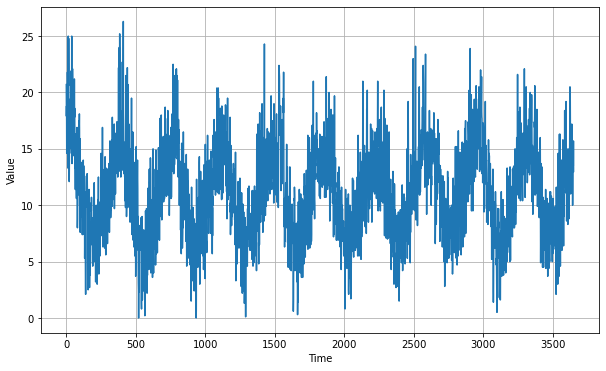

In [6]:
# Testing the function and saving all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TEMPERATURES_CSV = './data.csv'
    times, temperatures = parse_data_from_file(TEMPERATURES_CSV)
    TIME = np.array(times)
    SERIES = np.array(temperatures)
    SPLIT_TIME = 2500
    WINDOW_SIZE = 64
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000


plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

### Processing the data

In [7]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [8]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds


# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

### Defining the model architecture

In [9]:
def create_uncompiled_model():
    
    model = tf.keras.models.Sequential([ 
        tf.keras.layers.Conv1D(filters=32, kernel_size=5, 
                              strides=1, padding="causal",
                              activation='relu',
                              input_shape=[None, 1]),
        tf.keras.layers.LSTM(16, return_sequences=True),
        tf.keras.layers.LSTM(16),
        tf.keras.layers.Dense(12),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 27)
    ]) 

    return model

### Optimize Learning Rate

In [10]:
def adjust_learning_rate(dataset):
    
    model = create_uncompiled_model()
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))
    
    # Select the optimizer
    optimizer = tf.keras.optimizers.Adam()
    
    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer, 
                  metrics=["mae"]) 
    
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    
    return history

In [11]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate(train_set)

Epoch 1/100
77/77 [==============================] - 11s 55ms/step - loss: 2.1888 - mae: 2.6464 - lr: 1.0000e-04
Epoch 2/100
77/77 [==============================] - 4s 53ms/step - loss: 1.8812 - mae: 2.3331 - lr: 1.1220e-04
Epoch 3/100
77/77 [==============================] - 4s 53ms/step - loss: 1.8508 - mae: 2.3043 - lr: 1.2589e-04
Epoch 4/100
77/77 [==============================] - 5s 55ms/step - loss: 1.8318 - mae: 2.2847 - lr: 1.4125e-04
Epoch 5/100
77/77 [==============================] - 5s 56ms/step - loss: 1.7633 - mae: 2.2119 - lr: 1.5849e-04
Epoch 6/100
77/77 [==============================] - 5s 57ms/step - loss: 1.7743 - mae: 2.2267 - lr: 1.7783e-04
Epoch 7/100
77/77 [==============================] - 5s 59ms/step - loss: 1.8168 - mae: 2.2714 - lr: 1.9953e-04
Epoch 8/100
77/77 [==============================] - 5s 56ms/step - loss: 1.7079 - mae: 2.1563 - lr: 2.2387e-04
Epoch 9/100
77/77 [==============================] - 4s 54ms/step - loss: 1.6869 - mae: 2.1342 - lr: 2.

77/77 [==============================] - 4s 51ms/step - loss: 3.0454 - mae: 3.5149 - lr: 0.5012
Epoch 76/100
77/77 [==============================] - 4s 56ms/step - loss: 3.2611 - mae: 3.7298 - lr: 0.5623
Epoch 77/100
77/77 [==============================] - 5s 61ms/step - loss: 3.0556 - mae: 3.5255 - lr: 0.6310
Epoch 78/100
77/77 [==============================] - 5s 62ms/step - loss: 14.7937 - mae: 15.2680 - lr: 0.7079
Epoch 79/100
77/77 [==============================] - 5s 56ms/step - loss: 33.8163 - mae: 34.3027 - lr: 0.7943
Epoch 80/100
77/77 [==============================] - 5s 56ms/step - loss: 3.0292 - mae: 3.4979 - lr: 0.8913
Epoch 81/100
77/77 [==============================] - 4s 54ms/step - loss: 3.1170 - mae: 3.5884 - lr: 1.0000
Epoch 82/100
77/77 [==============================] - 4s 52ms/step - loss: 3.4808 - mae: 3.9538 - lr: 1.1220
Epoch 83/100
77/77 [==============================] - 5s 58ms/step - loss: 3.2421 - mae: 3.7154 - lr: 1.2589
Epoch 84/100
77/77 [========

(0.0001, 10.0, 0.0, 10.0)

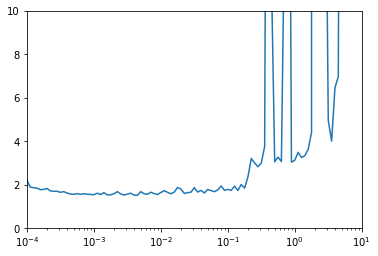

In [12]:
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-4, 10, 0, 10])

### Training the model with optimal LR

In [13]:
def create_model():
    model = create_uncompiled_model()
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
                  metrics=["mae"])  

    return model

In [14]:
# Save an instance of the model
model = create_model()

# Train it
history = model.fit(train_set, epochs=50)

Epoch 1/50
77/77 [==============================] - 10s 53ms/step - loss: 3.6192 - mae: 4.0846
Epoch 2/50
77/77 [==============================] - 4s 54ms/step - loss: 1.8234 - mae: 2.2751
Epoch 3/50
77/77 [==============================] - 5s 57ms/step - loss: 1.7000 - mae: 2.1504
Epoch 4/50
77/77 [==============================] - 5s 59ms/step - loss: 1.6144 - mae: 2.0628
Epoch 5/50
77/77 [==============================] - 5s 57ms/step - loss: 1.5229 - mae: 1.9663
Epoch 6/50
77/77 [==============================] - 5s 59ms/step - loss: 1.5510 - mae: 1.9917
Epoch 7/50
77/77 [==============================] - 5s 59ms/step - loss: 1.5243 - mae: 1.9688
Epoch 8/50
77/77 [==============================] - 4s 54ms/step - loss: 1.5059 - mae: 1.9473
Epoch 9/50
77/77 [==============================] - 4s 47ms/step - loss: 1.5084 - mae: 1.9490
Epoch 10/50
77/77 [==============================] - 5s 59ms/step - loss: 1.5263 - mae: 1.9695
Epoch 11/50
77/77 [==============================] - 5s 66

### Evaluating the forecast

In [15]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

In [16]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

113/113 [==============================] - 3s 15ms/step


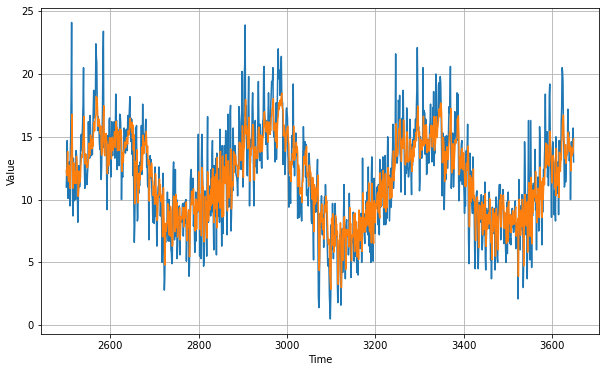

In [17]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [18]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 5.25, mae: 1.78 for forecast
